In [1]:

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import tensorflow as tf
from keras import layers


IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 512

# Size of the noise vector
noise_dim = 128

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# Reshape each sample to (28, 28, 1) and normalize the pixel values in the [-1, 1] range
train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5


def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

"""
## Create the generator
"""


def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()


Number of examples: 60000
Shape of the images in the dataset: (28, 28)

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 32, 32, 1)         0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)

In [2]:
"""
## Create the WGAN-GP model

Now that we have defined our generator and discriminator, it's time to implement
the WGAN-GP model. We will also override the `train_step` for training.
"""


class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}



In [3]:
import numpy as np 

# Callback personalizzato per salvare immagini, pesi e valori di loss
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128, save_dir="checkpoints", interval=1):
        """
        Callback to monitor GAN training, save generated images, losses, and weights.

        Args:
            num_img (int): Number of images to generate.
            latent_dim (int): Dimension of the latent space.
            save_dir (str): Directory to save images and checkpoints.
            interval (int): Save every 'interval' epochs.
        """
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save_dir = save_dir
        self.interval = interval
        os.makedirs(save_dir, exist_ok=True)
        os.makedirs(os.path.join(save_dir, "generated_images"), exist_ok=True)

        # Initialize lists to store losses
        self.generator_loss = []
        self.discriminator_loss = []

    def on_epoch_end(self, epoch, logs=None):
        # Save generated images
        if epoch % self.interval == 0:
            random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = (generated_images * 127.5) + 127.5

            for i in range(self.num_img):
                img = generated_images[i].numpy()
                img = keras.utils.array_to_img(img)
                img_path = os.path.join(self.save_dir, "generated_images", f"generated_img_{epoch}_{i}.png")
                img.save(img_path)

            # Save model weights
            self.model.generator.save_weights(os.path.join(self.save_dir, f"generator_weights_epoch_{epoch}.h5"))
            self.model.discriminator.save_weights(os.path.join(self.save_dir, f"discriminator_weights_epoch_{epoch}.h5"))

        # Log losses
        if logs:
            g_loss = logs.get("g_loss")  # Replace with correct generator loss key
            d_loss = logs.get("d_loss")  # Replace with correct discriminator loss key
            if g_loss is not None and d_loss is not None:
                self.generator_loss.append(g_loss)
                self.discriminator_loss.append(d_loss)
        
        # Save losses periodically, append if file already exists
        if epoch % self.interval == 0:
            loss_path = os.path.join(self.save_dir, "loss_data.npz")
            
            # Check if the file already exists
            if os.path.exists(loss_path):
                # Load the existing losses
                data = np.load(loss_path)
                existing_g_loss = data['generator_loss'].tolist()
                existing_d_loss = data['discriminator_loss'].tolist()
                
                # Append new losses to the existing ones
                existing_g_loss.extend(self.generator_loss)
                existing_d_loss.extend(self.discriminator_loss)

                # Save the updated losses back to the file
                np.savez(loss_path, generator_loss=existing_g_loss, discriminator_loss=existing_d_loss)
            else:
                # Save the new losses as a new file if it doesn't exist
                np.savez(loss_path, generator_loss=self.generator_loss, discriminator_loss=self.discriminator_loss)
            
            # Reset the losses to avoid duplication in future epochs
            self.generator_loss = []
            self.discriminator_loss = []


In [4]:

"""
## Train the end-to-end model
"""

# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)


# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)



In [ ]:

# Set the number of epochs for training.
epochs = 1

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])


-------------------------

# Load weights and show Losses

In [7]:

generator_weights_path = "checkpoints/weights/generator_weights_epoch_16.h5"  # Sostituisci X con l'epoca desiderata
discriminator_weights_path = "checkpoints/weights/discriminator_weights_epoch_16.h5"

# Caricare i pesi
try:
    g_model.load_weights(generator_weights_path)
    d_model.load_weights(discriminator_weights_path)
    print("Weights loaded successfully.")
except Exception as e:
    print(f"Error loading weights: {e}")


Weights loaded successfully.


In [9]:

# Set the number of epochs for training.
epochs = 30

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])


Epoch 1/30
118/118 [==============================] - 1283s 11s/step - d_loss: -2.8382 - g_loss: -6.0900
Epoch 2/30
118/118 [==============================] - 869s 7s/step - d_loss: -2.7559 - g_loss: -6.7079
Epoch 3/30
118/118 [==============================] - 868s 7s/step - d_loss: -2.6930 - g_loss: -5.5466
Epoch 4/30
118/118 [==============================] - 869s 7s/step - d_loss: -2.6072 - g_loss: -4.7658
Epoch 5/30
118/118 [==============================] - 867s 7s/step - d_loss: -2.5663 - g_loss: -4.1286
Epoch 6/30
118/118 [==============================] - 866s 7s/step - d_loss: -2.5402 - g_loss: -3.6944
Epoch 7/30
118/118 [==============================] - 867s 7s/step - d_loss: -2.4909 - g_loss: -3.7502
Epoch 8/30
118/118 [==============================] - 868s 7s/step - d_loss: -2.4374 - g_loss: -3.6444
Epoch 9/30
118/118 [==============================] - 866s 7s/step - d_loss: -2.4462 - g_loss: -3.0925
Epoch 10/30
118/118 [==============================] - 870s 7s/step - d

In [8]:
import numpy as np

# Carica il file .npz
data = np.load('checkpoints/losses.npz')

# Stampa le chiavi del file .npz
print("Chiavi nel file .npz:", data.files)

# Stampa i valori di ogni chiave
for key in data.files:
    print(f"Valori per {key}:")
    print(data[key])


Chiavi nel file .npz: ['generator_loss', 'discriminator_loss']
Valori per generator_loss:
[-13.91555309 -19.1837101  -13.48959351 -12.13476944 -15.90494061
 -10.18772888 -10.37808514  -6.43171644  -7.30421066 -11.9981308
 -10.39971352  -9.12022781  -6.96188879  -6.41760206  -6.44374704
  -7.68172264]
Valori per discriminator_loss:
[-6.05385876 -5.68821144 -5.68097305 -4.91748047 -4.92735481 -4.36383629
 -4.8384037  -4.11740303 -3.62406301 -3.45509529 -3.56052613 -3.61292791
 -3.28161287 -2.81453824 -3.29297853 -3.12044334]


-----------------------

### Save txt file into npz with values for generator and discriminiator and show them on a plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Leggi il file
file_path = 'MNIST_weight.txt'
epochs, d_loss, g_loss = [], [], []

with open(file_path, 'r') as file:
    for line in file:
        parts = line.split()
        epochs.append(int(parts[0]))
        d_loss.append(float(parts[2]))
        g_loss.append(float(parts[5]))

# Converti in formato .npz
np.savez('checkpoints/loss_data.npz', epochs=epochs, d_loss=d_loss, g_loss=g_loss)

In [2]:
# Carica il file .npz
data = np.load('checkpoints/loss_data.npz')

# Stampa le chiavi del file .npz
print("Chiavi nel file .npz:", data.files)

# Stampa i valori di ogni chiave
for key in data.files:
    print(f"Valori per {key}:")
    print(data[key])

Chiavi nel file .npz: ['epochs', 'd_loss', 'g_loss']
Valori per epochs:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Valori per d_loss:
[-7.6752 -6.9681 -6.0718 -5.5445 -5.0881 -4.7395 -4.2081 -3.9901 -3.7768
 -3.6129 -3.499  -3.3199 -3.16   -3.0694 -2.9825 -2.8804 -2.8382 -2.7559
 -2.693  -2.6072 -2.5663 -2.5402 -2.4909 -2.4374 -2.4462 -2.3549 -2.3546
 -2.2772 -2.2556 -2.259  -2.2402 -2.2112 -2.1893 -2.1356 -2.1151 -2.1302
 -2.1131 -2.0921 -2.0723 -2.0743 -2.0349 -2.0293 -1.9997 -1.9901 -1.9728
 -1.9593]
Valori per g_loss:
[-17.7237 -14.9377 -14.7574 -13.5938 -12.1444 -10.6129  -9.5069  -8.7396
  -8.1725  -7.7885  -7.6892  -7.5819  -7.3688  -7.0693  -6.9525  -5.8865
  -6.09    -6.7079  -5.5466  -4.7658  -4.1286  -3.6944  -3.7502  -3.6444
  -3.0925  -3.6394  -3.456   -2.9089  -3.2844  -2.806   -2.6732  -2.5272
  -2.3517  -2.7112  -2.4176  -2.5528  -2.7499  -3.0628  -2.7343  -2.6826
  -2.8965

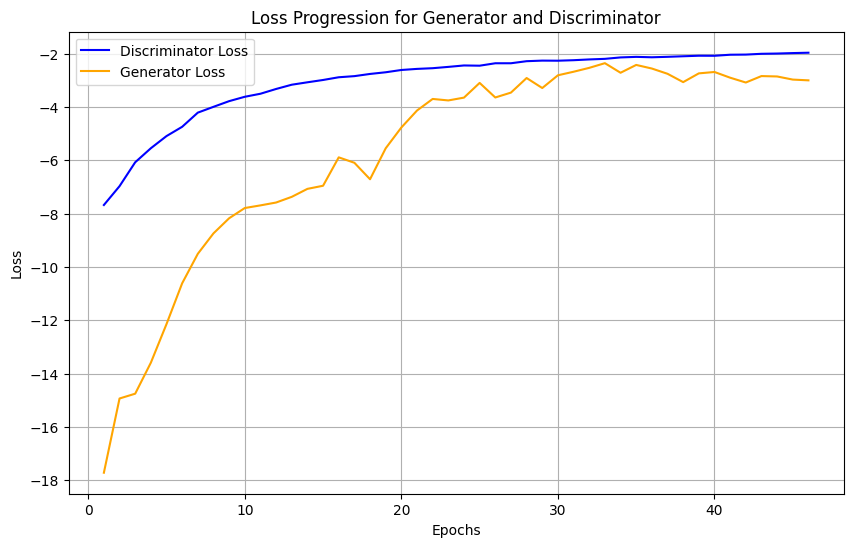

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, d_loss, label='Discriminator Loss', color='blue')
plt.plot(epochs, g_loss, label='Generator Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Progression for Generator and Discriminator')
plt.legend()
plt.grid()
plt.savefig('checkpoints/loss_plot.png')  # Salva il grafico come immagine
plt.show()

--------------------

### Show Generated Images

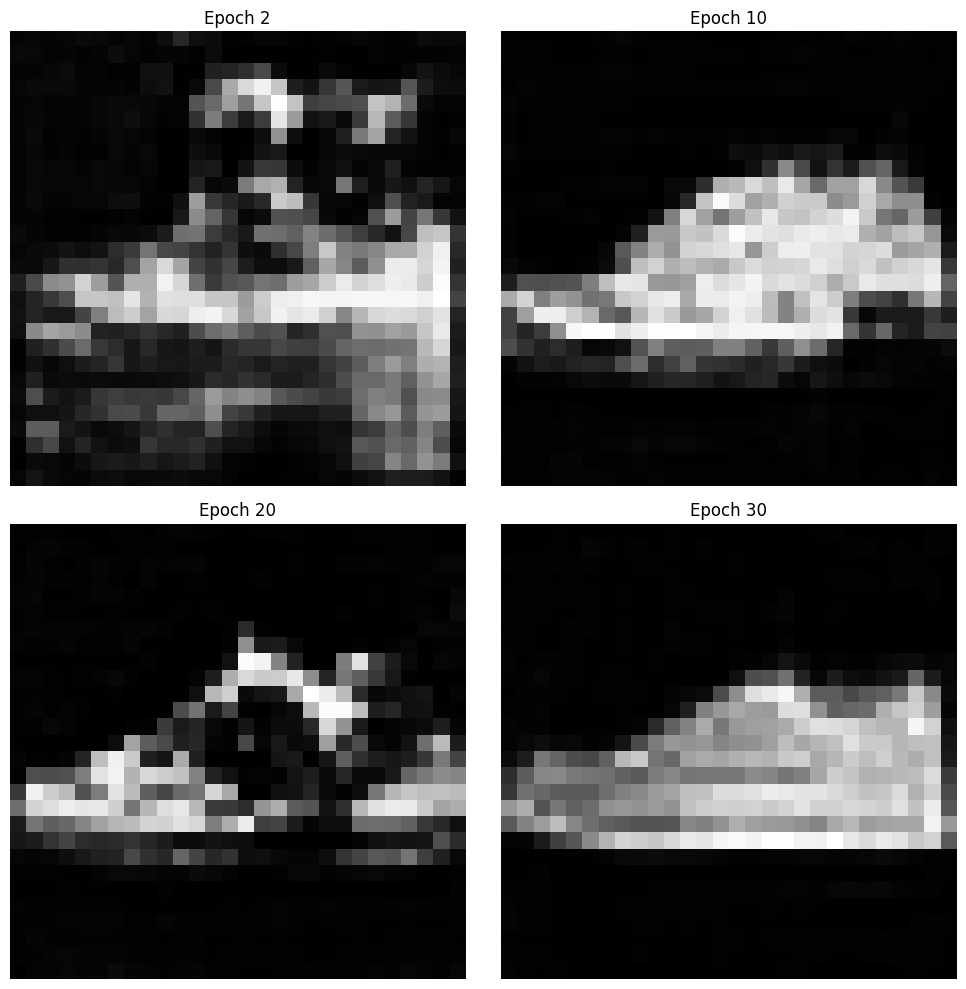

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Percorsi delle immagini
images = [
    ("checkpoints/generated_images/generated_img_2_2.png", "Epoch 2"),
    ("checkpoints/generated_images/generated_img_10_0.png", "Epoch 10"),
    ("checkpoints/generated_images/generated_img_19_0.png", "Epoch 20"),
    ("checkpoints/generated_images/generated_img_29_0.png", "Epoch 30")
]

# Creazione della figura e della griglia
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Loop per caricare e visualizzare le immagini
for ax, (img_path, title) in zip(axes.flatten(), images):
    img = mpimg.imread(img_path)  # Carica l'immagine
    ax.imshow(img,cmap="grey")               # Mostra l'immagine
    ax.set_title(title, fontsize=12)  # Aggiungi titolo (epoca)
    ax.axis("off")               # Nascondi assi

# Regola spazi tra le immagini
plt.tight_layout()

# Salva la griglia come immagine o mostra il plot
plt.savefig("grid_plot.png")  # Salva la griglia
plt.show()                    # Mostra la griglia
